In [1]:
from datasets import load_dataset
import huggingface_hub
import torch
import torchvision
import matplotlib.pyplot as plt

#huggingface_hub.login()
dataset = load_dataset("imagenet-1k", split="validation", trust_remote_code=True, streaming=True)

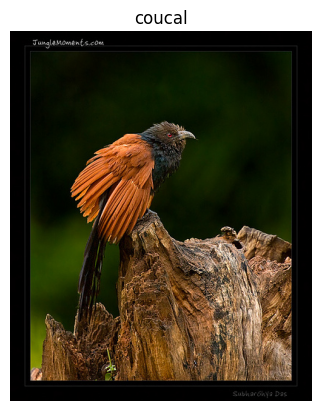

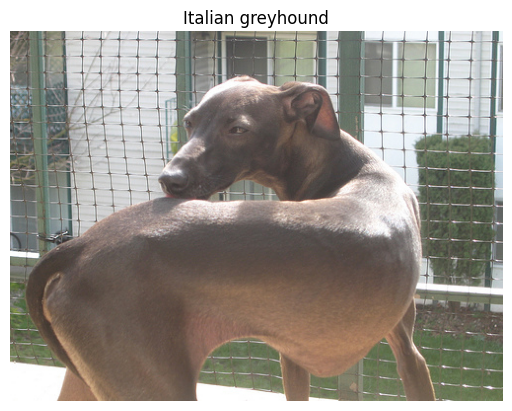

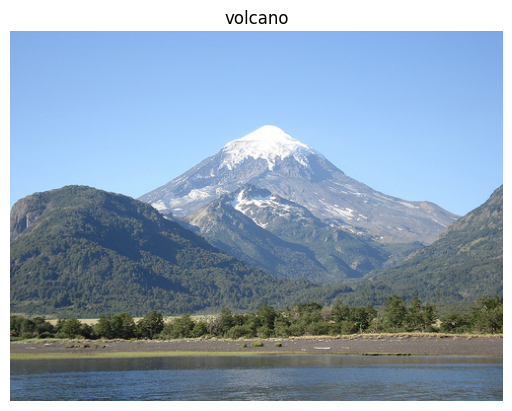

In [2]:
for i, example in enumerate(dataset):
    plt.imshow(example["image"])
    plt.title(dataset.features["label"].names[example["label"]])
    plt.axis("off")
    plt.show()
    

    if i + 1 == 3:
        break

In [3]:
# load alexnet
model = torchvision.models.vgg11_bn(weights=torchvision.models.VGG11_BN_Weights.DEFAULT)
model.eval()

# preprocess the image
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
image = transform(example["image"]).unsqueeze(0)

# put model and image on cuda
model = model.cuda()
image = image.cuda()

# predict the label
with torch.no_grad():
    logits = model(image)
    predicted_label = logits.argmax(-1)
    print(f"Predicted label: {dataset.features['label'].names[predicted_label]}")
    print(f"Certainty: {torch.nn.functional.softmax(logits, dim=-1).max() * 100:.2f}%")
    print("---")
    print(f"True label: {dataset.features['label'].names[example['label']]}")

Predicted label: volcano
Certainty: 30.15%
---
True label: volcano


In [4]:
fool_label = 950
print(f"Fooling the model to predict: {dataset.features['label'].names[fool_label]}")

Fooling the model to predict: orange


Loss: 7.915321350097656
Loss: 35.24843978881836
Loss: 9.038928031921387
Loss: 3.3529303073883057
Loss: 1.2526144981384277
Loss: 0.4792187511920929
Loss: 0.1865163892507553
Loss: 0.07713662832975388
Loss: 0.03675277531147003
Loss: 0.02154681831598282
Predicted label: orange
Certainty: 99.84%
---
True label: volcano


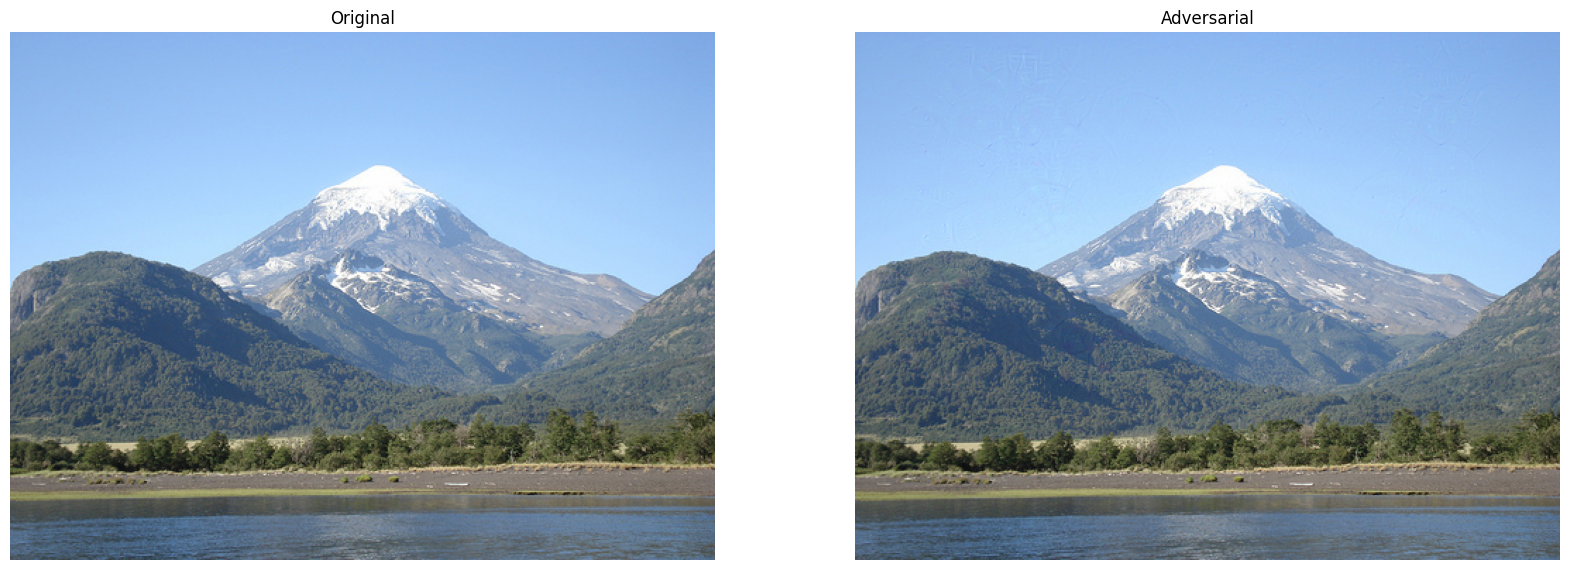

In [6]:
# freeze all model weights
for param in model.parameters():
    param.requires_grad = False

# create noise image
adversarial_noise = torch.zeros_like(image, requires_grad=True)

# create optimizer
optimizer = torch.optim.Adam([adversarial_noise], lr=0.1)

# create loss function
label_loss = torch.nn.CrossEntropyLoss()
change_loss = lambda x: torch.nn.functional.mse_loss(x, torch.zeros_like(x))

# create target label
target_label = torch.tensor([fool_label]).cuda()

# How strong the noise is penalized (higher = less noise)
alpha_change = 1000

# train the adversarial noise
for i in range(100):
    optimizer.zero_grad()
    adversarial_image = torch.clamp(image + adversarial_noise, 0, 1)
    logits = model(adversarial_image)
    loss = label_loss(logits, target_label) + alpha_change * change_loss(adversarial_noise)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Loss: {loss.item()}")

# predict the label
modified_image = torch.clamp(image + adversarial_noise, 0, 1)

with torch.no_grad():
    logits = model(modified_image)
    predicted_label = logits.argmax(-1)
    print(f"Predicted label: {dataset.features['label'].names[predicted_label]}")
    print(f"Certainty: {torch.nn.functional.softmax(logits, dim=-1).max() * 100:.2f}%")
    print("---")
    print(f"True label: {dataset.features['label'].names[example['label']]}")
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0].permute(1, 2, 0).cpu())
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(modified_image[0].permute(1, 2, 0).cpu())
    plt.title("Adversarial")
    plt.axis("off")
    plt.show()
